# Data Visualization
In this chapter we will visualize the data, hoping to find clues and information for future feature engineering and selection steps

In [47]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

#Random Seed Constant
random_seed = 420

#set numpy random seed 
np.random.seed(random_seed)

sns.set_palette('Dark2')
plt.rcParams["figure.figsize"] = (12,4)

## 1. Load Data

In [48]:
df = pd.read_pickle('../data/03_processed/BADS_WS2021_known_processed_all_cols.pkl')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100001 to 200000
Data columns (total 26 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   order_date                            100000 non-null  datetime64[ns]
 1   delivery_date                         100000 non-null  datetime64[ns]
 2   item_id                               100000 non-null  category      
 3   item_size                             100000 non-null  category      
 4   item_color                            100000 non-null  category      
 5   brand_id                              100000 non-null  category      
 6   item_price                            100000 non-null  float32       
 7   user_id                               100000 non-null  category      
 8   user_title                            100000 non-null  category      
 9   user_dob                              100000 non-null 

## 2. Correlations in the Data
We will now look at possible correlations in the data, starting with the numeric features and then looking at categorical features

In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
item_price,100000.0,65.111557,47.989960,0.0,29.9,49.900002,79.900002,999.0
return,100000.0,0.458180,0.498251,0.0,0.0,0.000000,1.000000,1.0
delivery_days,100000.0,3.394830,1.975130,0.0,2.0,3.000000,4.000000,7.0
user_account_age,100000.0,273.489420,223.034788,-1.0,23.0,261.000000,503.000000,572.0
user_age,100000.0,50.991180,8.364495,31.0,46.0,51.000000,56.000000,71.0
total_orders_by_user,100000.0,1.288970,1.943009,0.0,0.0,0.000000,2.000000,5.0
has_bought_item_before,100000.0,0.071620,0.257859,0.0,0.0,0.000000,0.000000,1.0
is_first_purchase,100000.0,0.702240,0.457276,0.0,0.0,1.000000,1.000000,1.0
number_of_items_in_order,100000.0,6.624260,5.952656,1.0,3.0,5.000000,8.000000,60.0
ordered_item_multiple_times_in_order,100000.0,0.328270,0.469586,0.0,0.0,0.000000,1.000000,1.0


## 2.1 Correlation between numeric variables

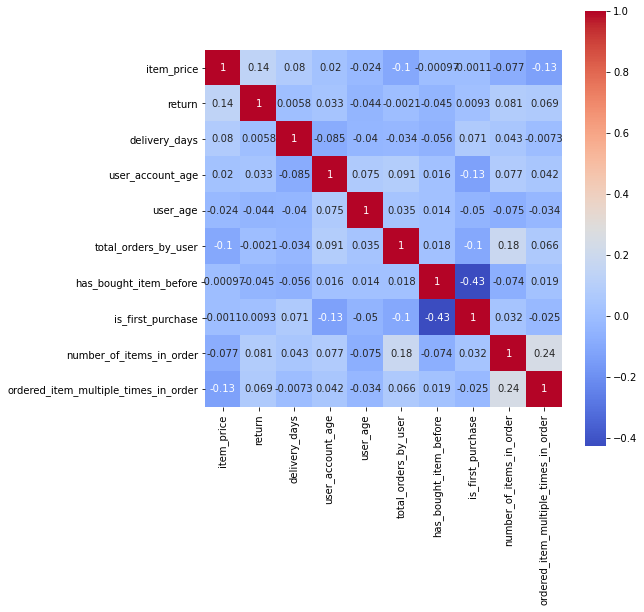

In [52]:
plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(data=df.astype({'return': 'int64'}).corr(),annot=True, cmap='coolwarm', square = True);

The `item_price` seems to be the only feature that has a somewhat meaningful impact on return.

Obviously `is_first_purchase` and `has_bought_item_before` have a strong negative correlation since users making their first purchase never made an order before.

Similarily `number_of_items_in_order` is positively correlated with `ordered_item_multiple_times_in_order`.

## 2.1 Correlation between categorical variables

In order to find possible correlations between the categorical features, we could users Cramer's V, since it is often more appropriate than Pearson correlation. 

In [53]:
from scipy.stats import chi2_contingency

In [54]:
def cramers_corrected_stat(contingency_table):
    """
        Computes corrected Cramer's V statistic for categorial-categorial association
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    
    r, k = contingency_table.shape
    r_corrected = r - (((r-1)**2)/(n-1))
    k_corrected = k - (((k-1)**2)/(n-1))
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    return (phi2_corrected / min( (k_corrected-1), (r_corrected-1)))**0.5

In [56]:
def categorical_corr_matrix(df):
    """
        Computes corrected Cramer's V statistic between all the categorical variables in the dataframe
    """
    df['return'] = df['return'].astype('category')
    df = df.select_dtypes(include='category')
    cols = df.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n, n)), index=cols, columns=cols)
    
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
                break
            df_crosstab = pd.crosstab(df[col1], df[col2], dropna=False)
            corr_matrix.loc[col1, col2] = cramers_corrected_stat(df_crosstab)
    
    # Flip and add to get full correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

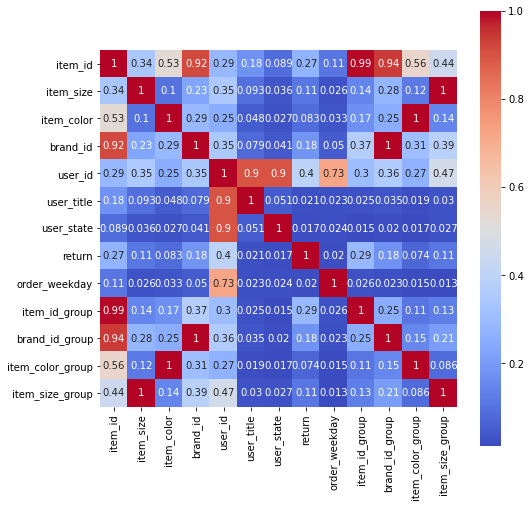

In [57]:
plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(categorical_corr_matrix(df), annot=True, cmap='coolwarm', square=True);

#### Discussion

- As expected, the generated groups based on WOE values are correlated to their raw counterparts.
* `user_id` and `item_id` seem to have a high correlation with return, suggesting a strong influence
* `user_id` seems to be strongly correlated with `user_state` and `user_title`
* as expected, `item_id` is highly correlated with `brand_id`, suggesting combining these features later on might be a good idea
* `item_size` and `item_color` are also highly correlated, this was to be expected, however the amount of correlation demands further investigation
* `item_color` and and `item_id` show a substantial correlation 

# 3. Data Visualization

### 3.1 Numeric Data

In [51]:
# Leave out the 4 outliers that are over 400 so plots dont get distorted
df_item_prices = df[df['item_price'] < 400]

/Users/davidburghoff/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_price', ylabel='Density'>

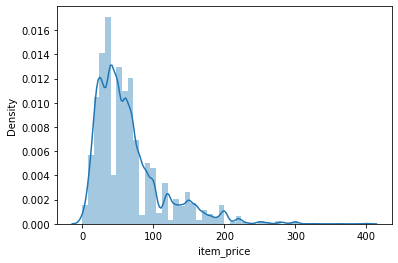

In [8]:
sns.distplot(df_item_prices['item_price'])

Above the distribution of `item_prices` can be seen. It does not follow a gaussian distribution, rather many values in the lower price segment can be observed, with decreasing density for higher values.

<AxesSubplot:xlabel='return', ylabel='item_price'>

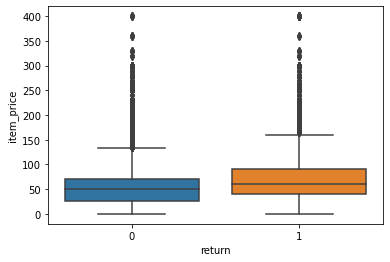

In [9]:
sns.boxplot(x="return", y="item_price", data=df_item_prices)

When grouping `item_price`'s by `return` and showing a boxplot, it can be observed that items that are returned are overall more expensive than items that are not returned. This observation suggests that `item_price` can be a good predictor for whether items will be returned or not.

## 3.2 Percantage Returns

In [86]:
df['return'] = df['return'].astype(int)

<Figure size 576x576 with 0 Axes>

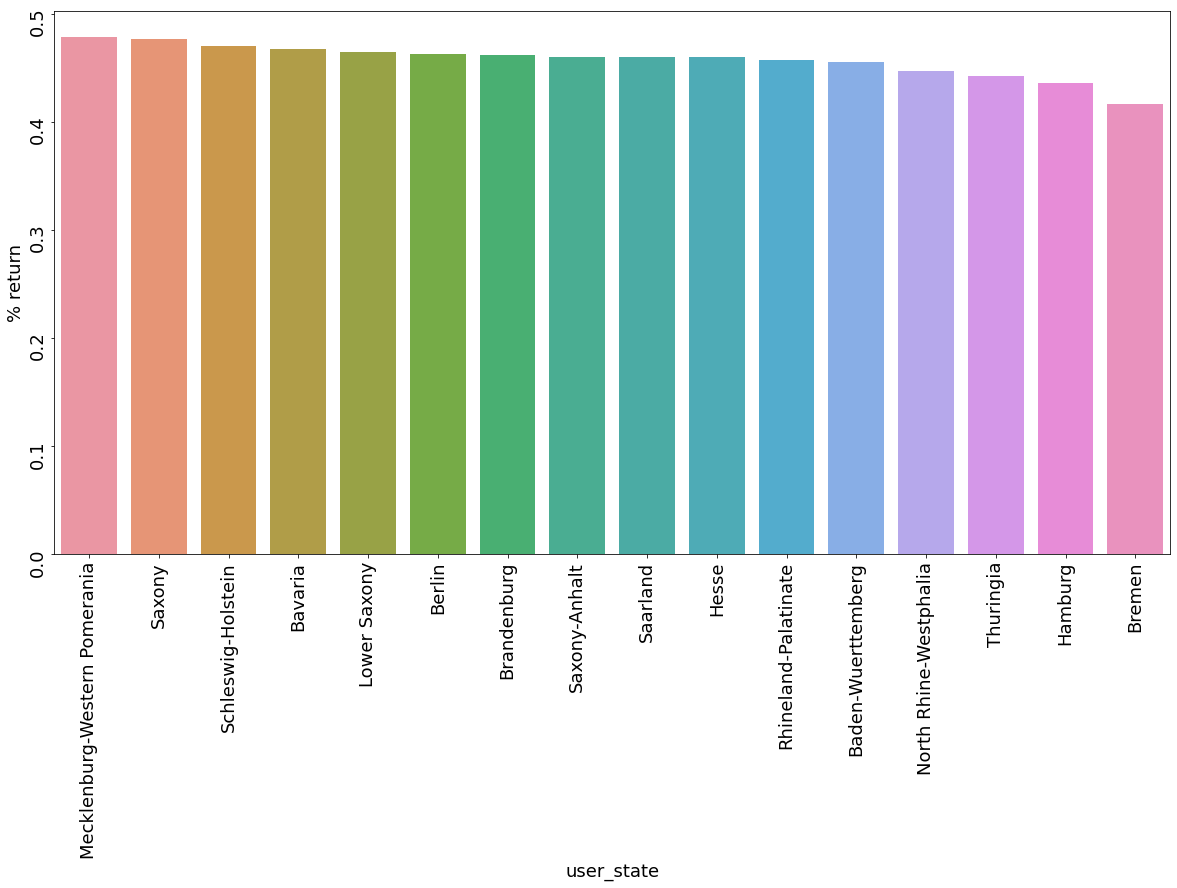

<Figure size 576x576 with 0 Axes>

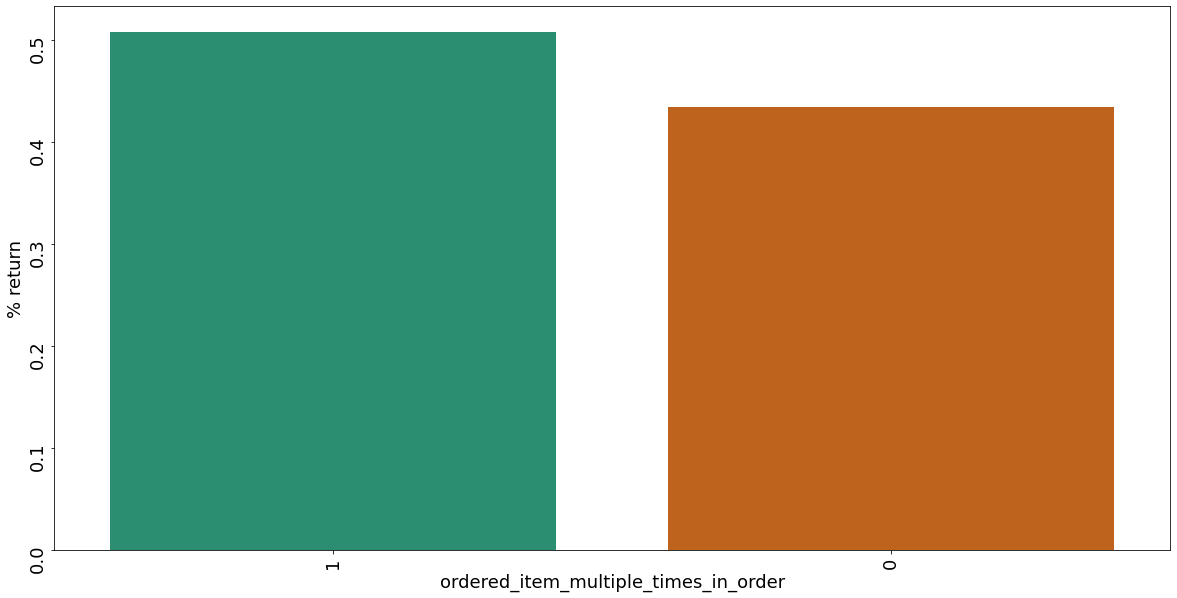

<Figure size 576x576 with 0 Axes>

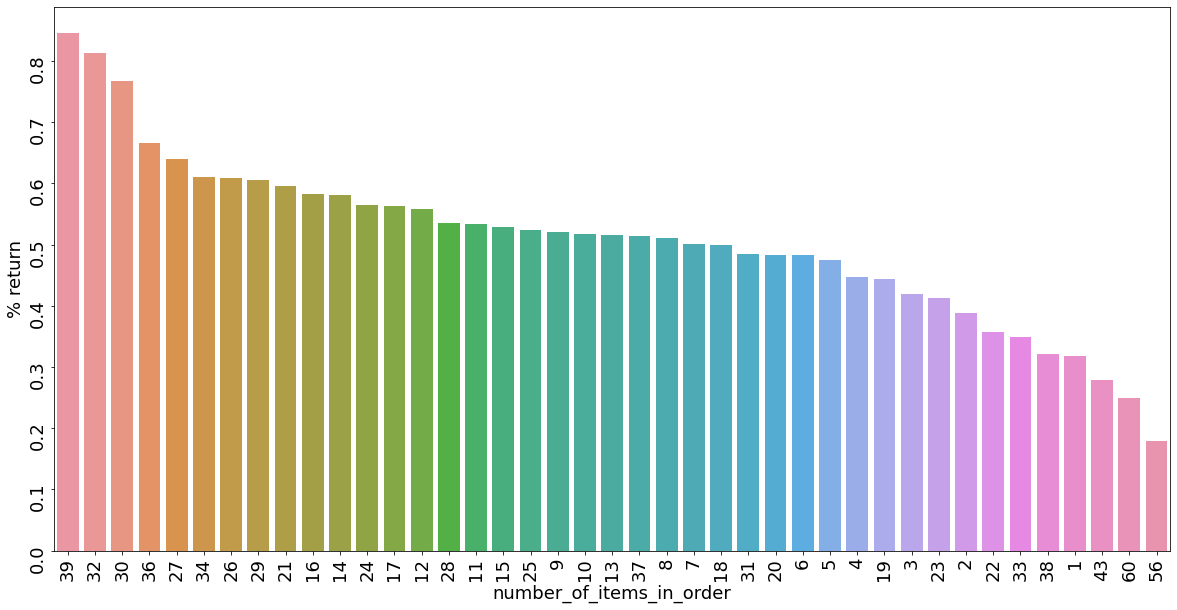

<Figure size 576x576 with 0 Axes>

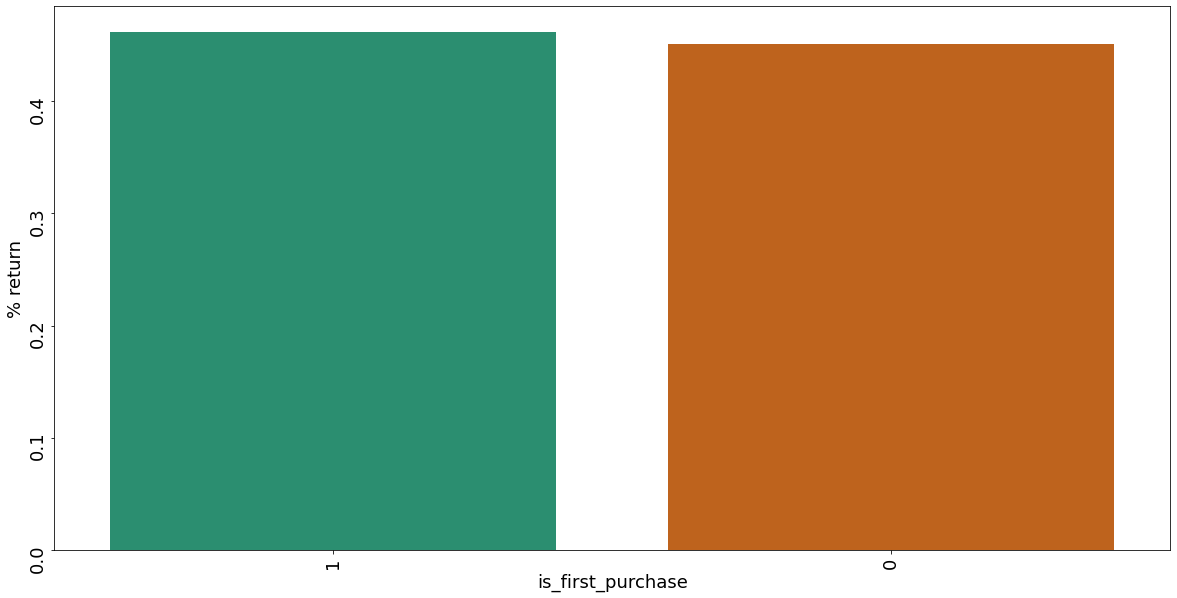

<Figure size 576x576 with 0 Axes>

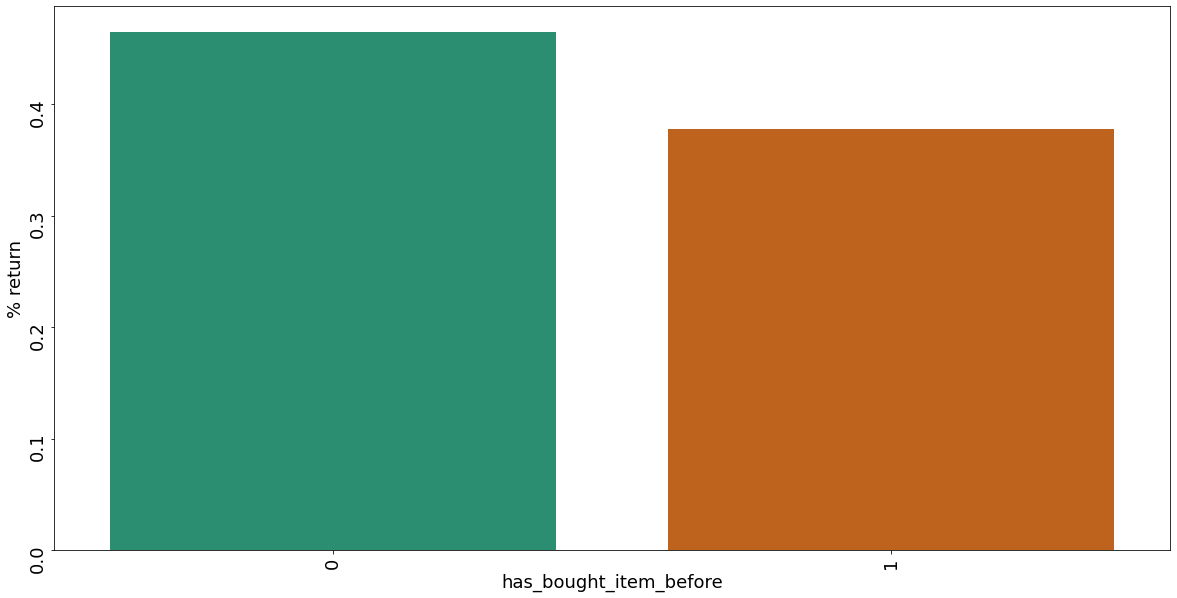

<Figure size 576x576 with 0 Axes>

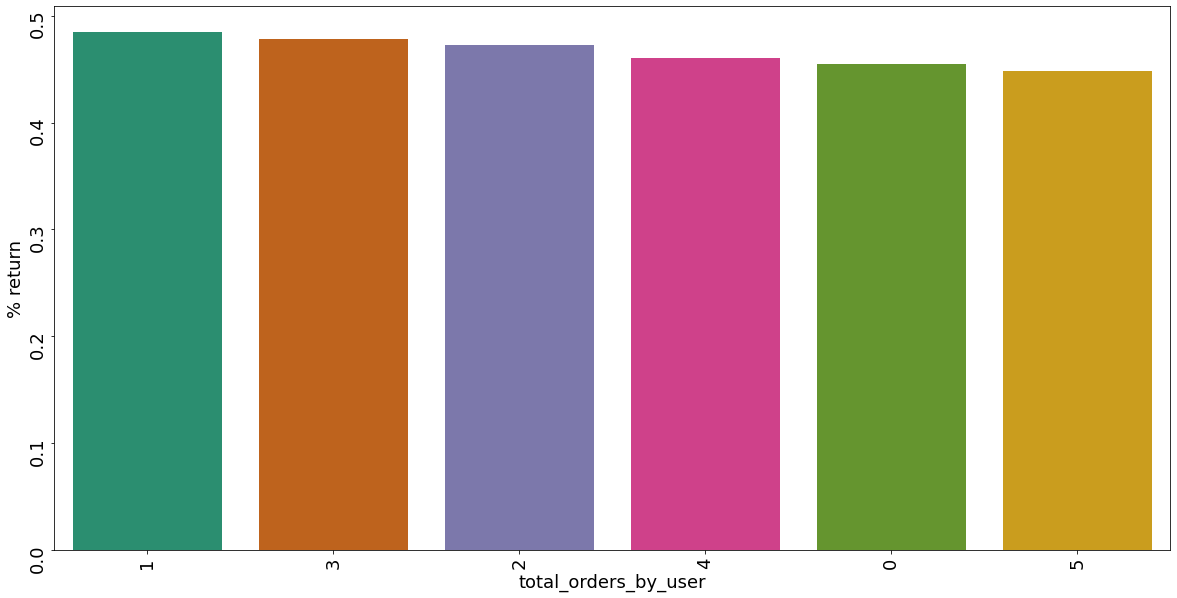

<Figure size 576x576 with 0 Axes>

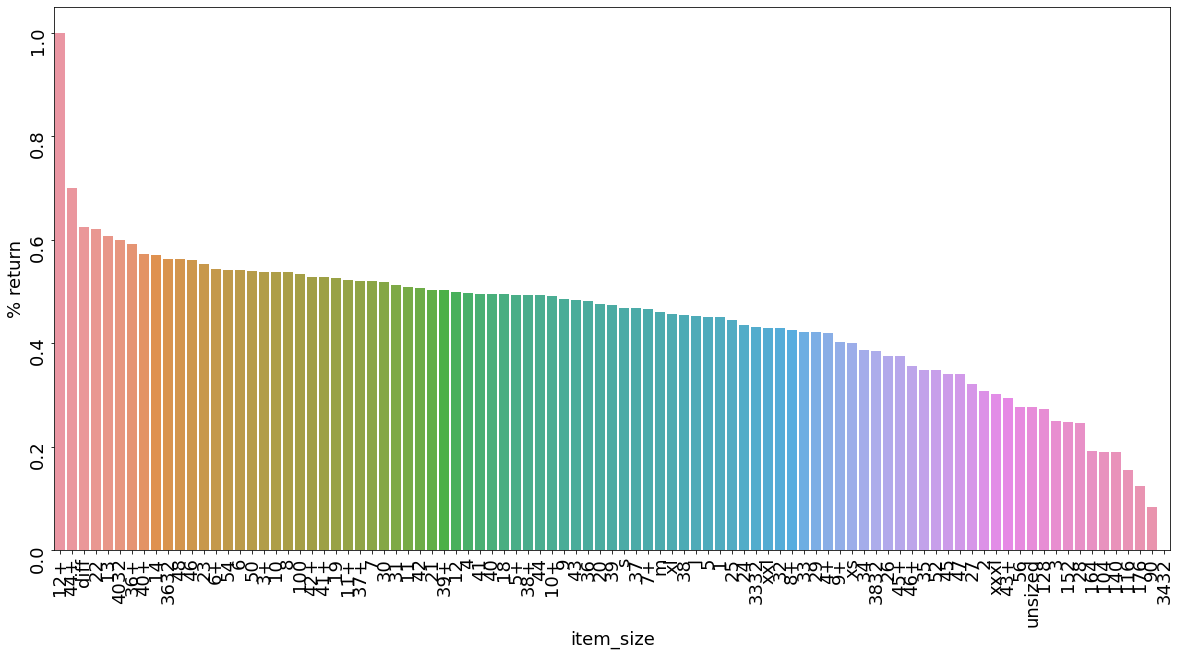

<Figure size 576x576 with 0 Axes>

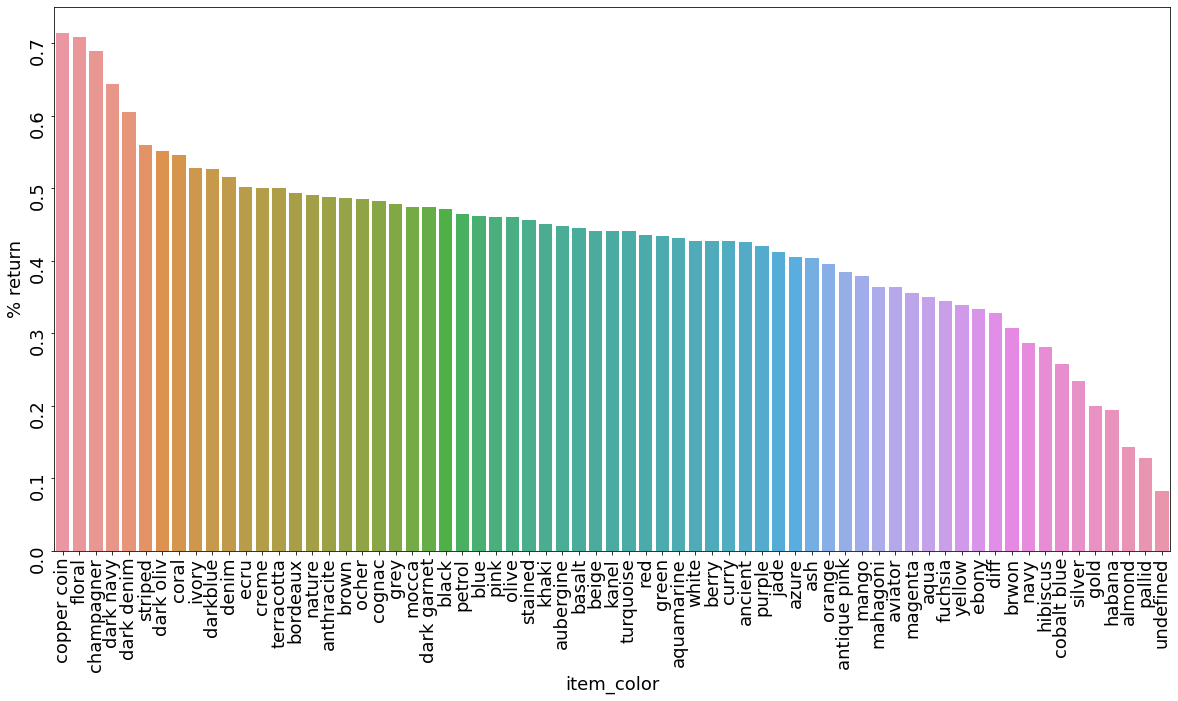

<Figure size 576x576 with 0 Axes>

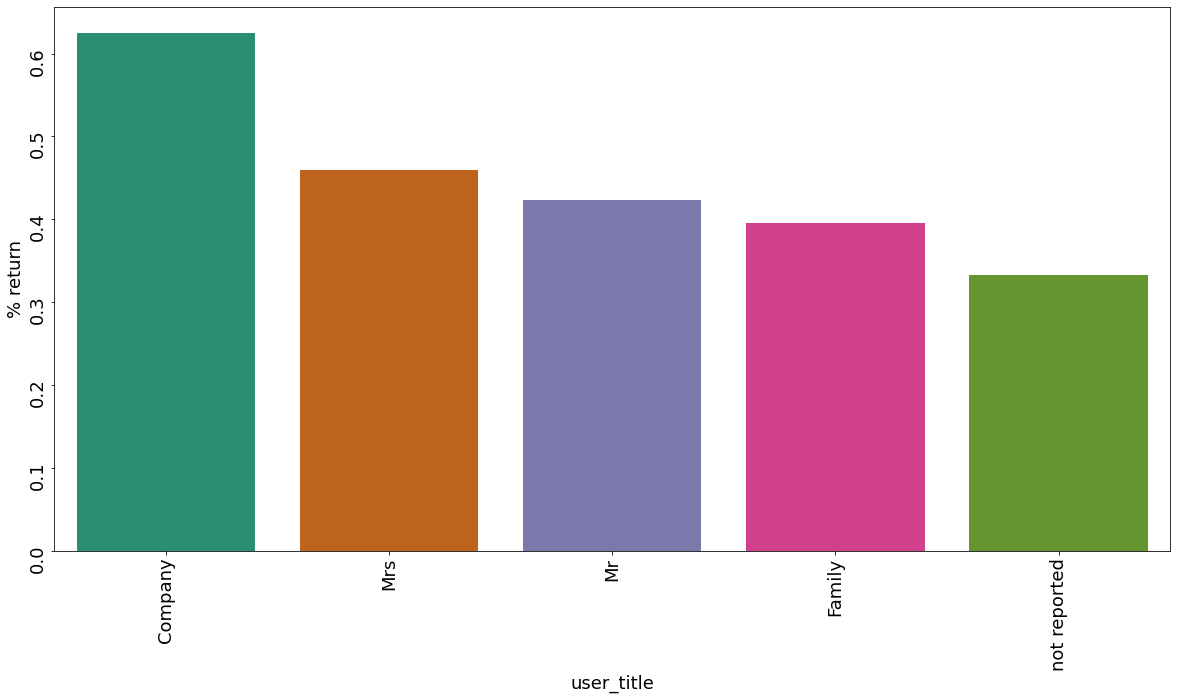

<Figure size 576x576 with 0 Axes>

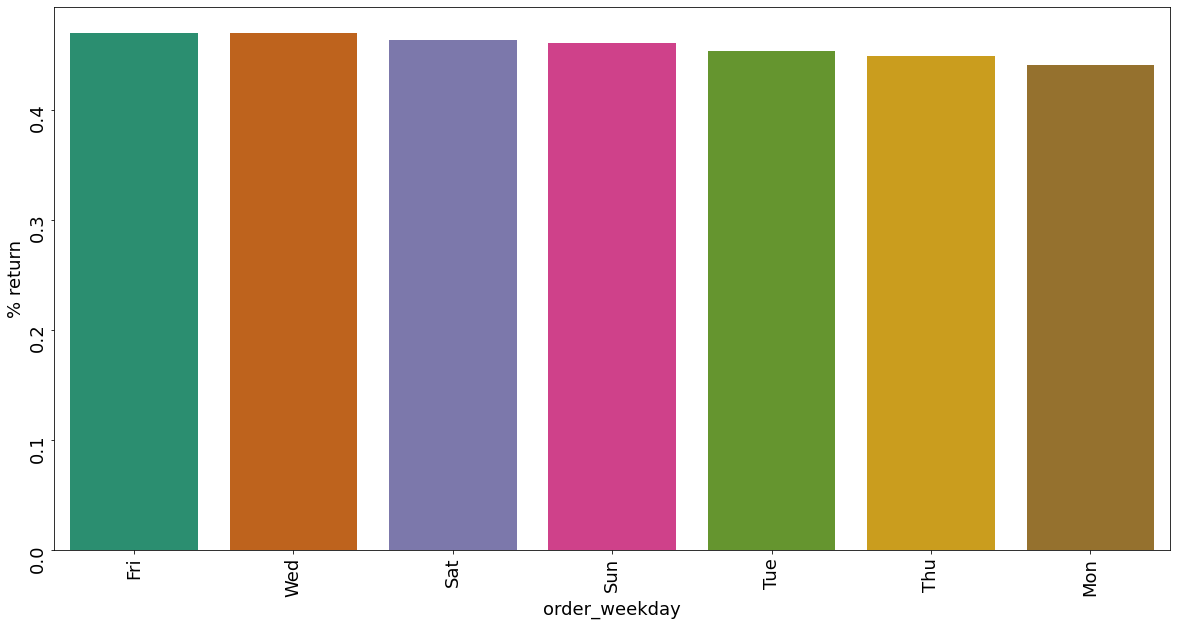

<Figure size 576x576 with 0 Axes>

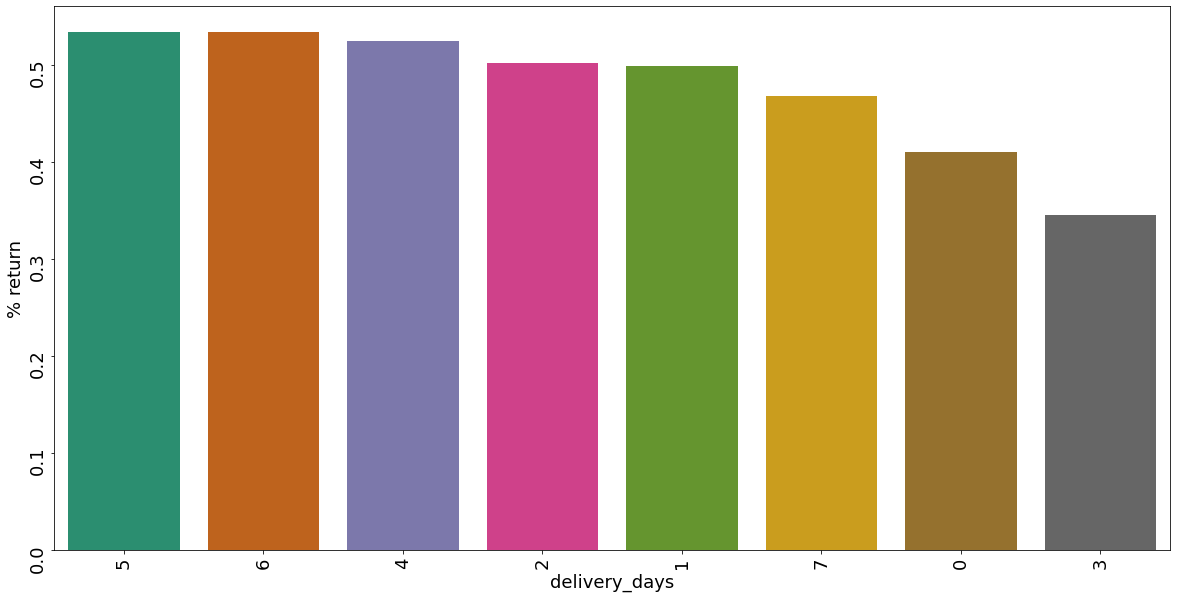

<Figure size 576x576 with 0 Axes>

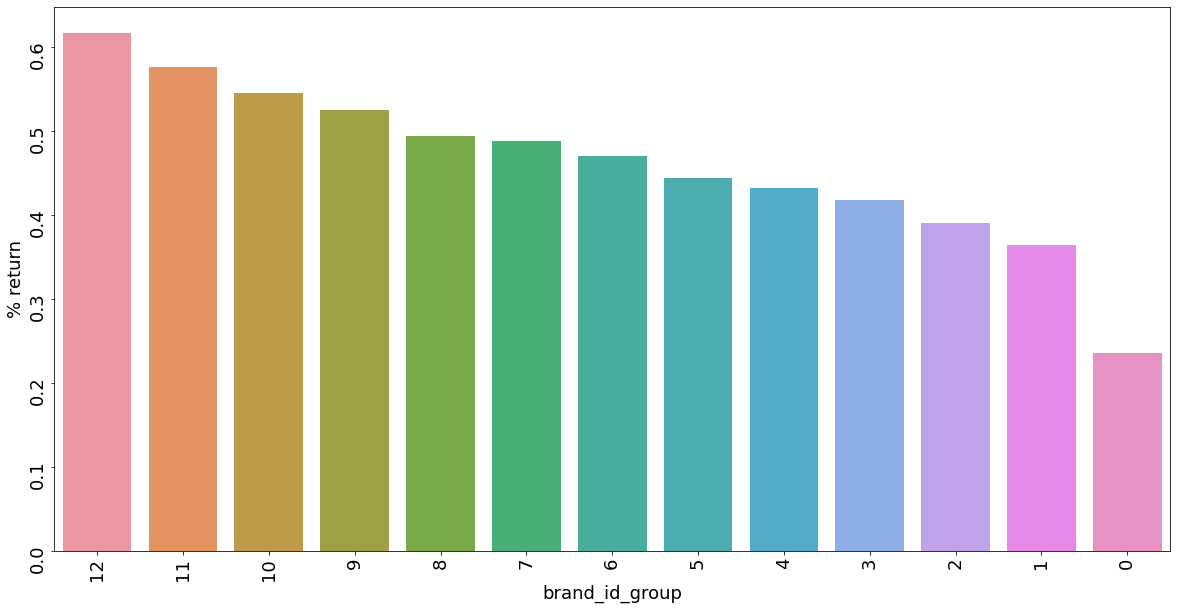

<Figure size 576x576 with 0 Axes>

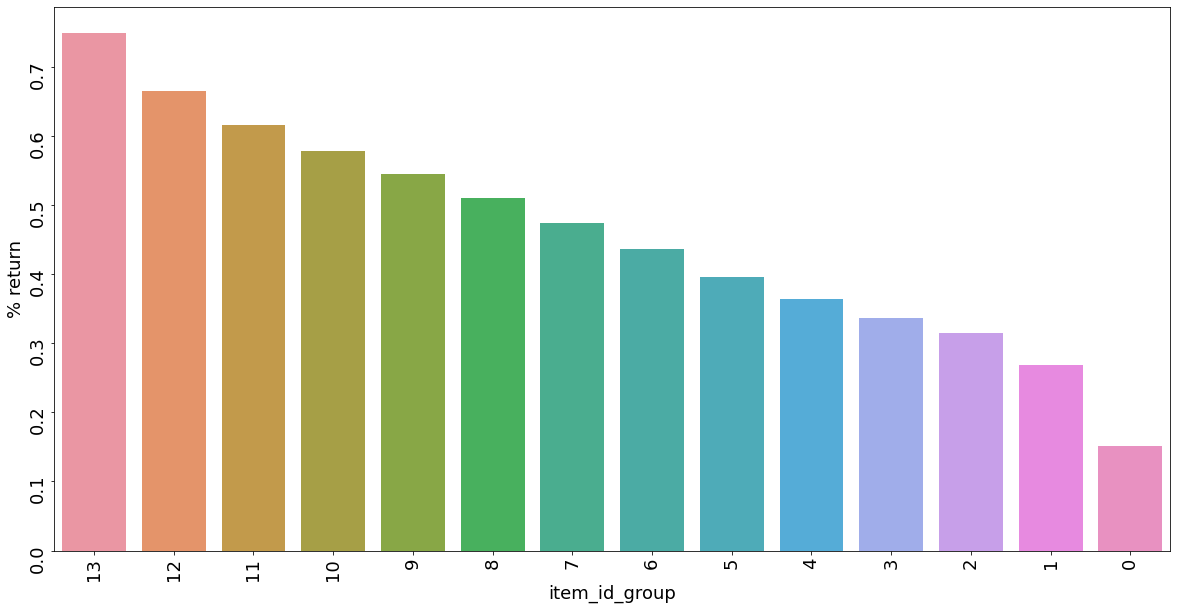

In [92]:
v = ['user_state',
    'ordered_item_multiple_times_in_order',
    'number_of_items_in_order',
    'is_first_purchase',
    'has_bought_item_before',
    'total_orders_by_user',
    'item_size',
    'item_color',
    'user_title',
    'order_weekday',
    'delivery_days',
    'brand_id_group',
    'item_id_group'
   ]

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    
    # Calculate the percentage of return=1 per category value
    cat_perc = df[[f, 'return']].groupby([f], as_index=False)['return'].mean()
    cat_perc.sort_values(by='return', ascending=False, inplace=True)
    
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='return', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% return', fontsize=18)
    plt.xlabel(f'{f}', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18, labelrotation=90)
    plt.show();

| Feature| Notes |
|--|:--:|
|User State | Inconclusive, except maybe Bremen with low % of returns |
|Ordered Item multiple times |Difference of return % of roughly 0.05, might be a helpful indicator |
|# of items in order |Clear trend visible, the more items were ordered in a given day, the more likely some of them are returned |
|First purchase of user | Only minor differences, seems to be a bad predictor| 
|Has bought same item before | As expected, the probability of returns decreases when a user has ordered the item before| 
|Total orders by user | Inconclusive, no visible trend| 
|Item Size | Some item sizes show very high % of returns while others are very low, might be a good predictor| 
|Item Color | Some colors show very high % of returns while others are very low, might be a good predictor| 
|User Title | Companies have a much higher % of returns, might also be a good predictor| 
|Order Weekday | Inconclusive, no real trend| 
|Delivery Days | The more delivery days it takes, the higher the % of returns, exception: 7| 
|Brand ID | Strong differences between groups, could be a good predictor |
|Item ID |Strong differences between groups, could be a good predictor |

## 3.3 Frequency Distribution: Categorical Features

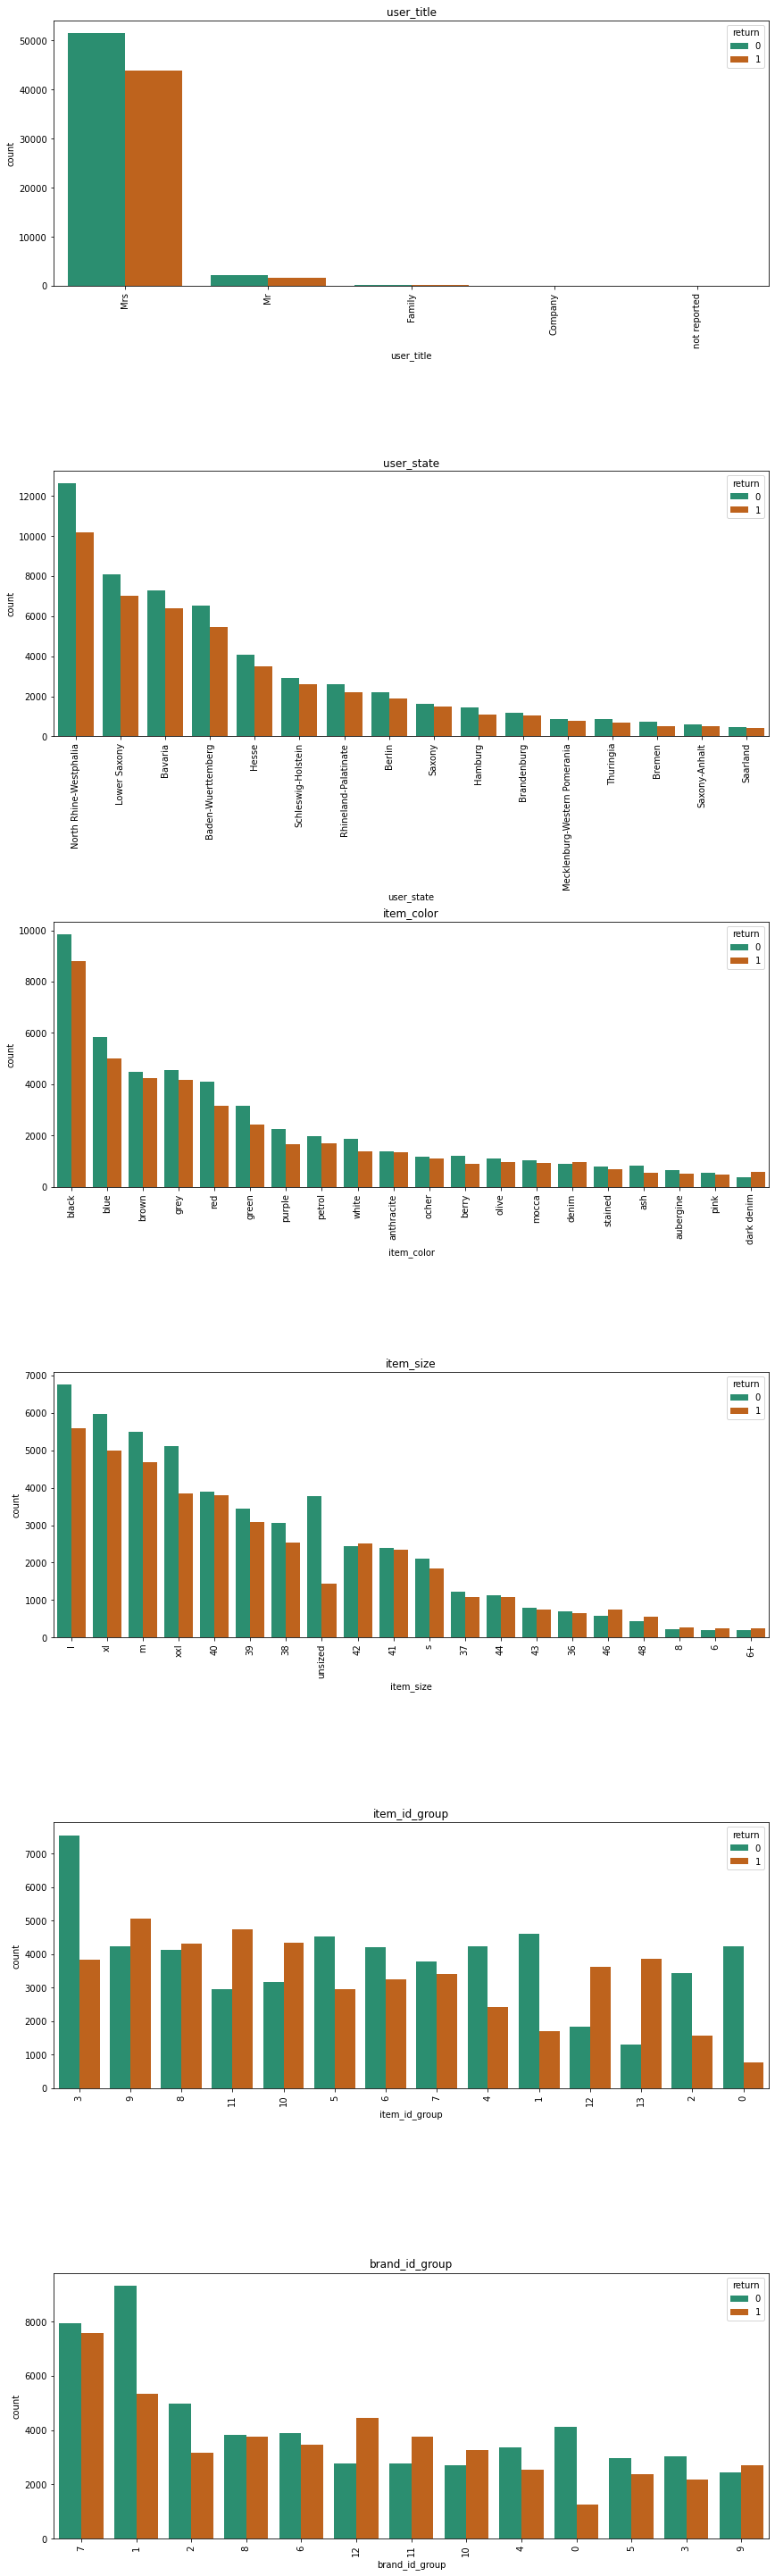

In [171]:
titles = ['user_title',
          'user_state',
          'item_color',
          'item_size',
          'item_id_group',
          'brand_id_group',
          
         ]
fig, axs = plt.subplots(nrows=len(titles), ncols=1, figsize=(12,40))
ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    category_levels = list(df[title].value_counts().index) # get category levels ordered by value counts
    if len(category_levels) > 20: # only show top 20 category levels
        category_levels = category_levels[:20]
        
    _df = df.loc[df[title].isin(category_levels)]
    # make countplot
    sns.countplot(x=title, data=_df, ax=ax, hue='return', order=category_levels)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
plt.tight_layout(pad=0.5)